# Medical Specialty Classification

**Team 3:**

* Balachander Srinivasan

* Christopher Umbel

* Mahfuzur Rahman

**Course:** AI 574 – Natural Language Processing (Summer, 2025)

### Problem Statement

* Medical transcriptions are unstructured reports containing valuable clinical information. Manually reviewing and categorizing these transcripts is time-consuming and costly. Without proper topic labels, it becomes difficult to organize patient records efficiently. Classifying these transcriptions into relevant medical topics can improve information retrieval, reduce delays, and support decision-making.

* **Keywords:** medical specialty classification, natural language processing, medical transcription, information retrieval, clinical decision support.

### Data Collection

* **Source(url):** https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data

* **Short Description:** The data set of anonymized medical transcription reports from Boyle (2018)

* **Keywords:** description, medical_specialty, sample_name, transcription, and keywords

### Required packages

Run the following command to install the required packages:
```
pip install -r ./requirements.txt

```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
import torch

from data_utils import DataUtils

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Data Exploration

In [4]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'data/mtsamples.csv'

In [5]:
df = pd.read_csv(DATASET_PATH, index_col=0)
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


,description,medical_specialty,sample_name,transcription,keywords
3994,"Incision and drainage, first metatarsal head,...",Discharge Summary,Abscess with Cellulitis - Discharge Summary,"ADMITTING DIAGNOSIS:, Abscess with cellulitis...","discharge summary, accutane, metatarsal head l..."
3502,Chronic cholecystitis. Laparoscopic cholecy...,Gastroenterology,Laparoscopic Cholecystectomy - 8,"PREOPERATIVE DIAGNOSIS: , Chronic cholecystiti...","gastroenterology, abdomen, bovie cautery, endo..."
555,"Medial branch rhizotomy, lumbosacral. Fluoro...",Surgery,Medial Branch Rhizotomy,"PROCEDURE: , Medial branch rhizotomy, lumbosac...","surgery, lumbosacral, medial branch rhizotomy,..."
4527,Patient with palpitations and rcent worsening...,Consult - History and Phy.,Chest discomfort & palpitations - Consult.,"CHIEF COMPLAINT:, Palpitations.,CHEST PAIN / U...",NaN
4403,2-year-old female who comes in for just reche...,Consult - History and Phy.,Gen Med Consult - 19,"SUBJECTIVE:, This is a 2-year-old female who ...","consult - history and phy., chronic lung disea..."
153,Circumcision. The child appeared to tolerate...,Urology,Circumcision - Child,"PROCEDURE: , Circumcision.,Signed informed con...","urology, circumstraint, dorsal slit, gomco cla..."
1136,Diagnostic bronchoscopy and limited left thor...,Surgery,Bronchoscopy & Thoracotomy,"PREOPERATIVE DIAGNOSES,1. Bilateral bronchopn...","surgery, chest tubes, insertion, partial pulmo..."
615,Diagnostic laparoscopy and rigid sigmoidoscop...,Surgery,Laparoscopy & Sigmoidoscopy,"PREOPERATIVE DIAGNOSES:,1. Acute pain.,2. Fe...","surgery, uterine perforation, vascular, bowel,..."
550,Right pleural effusion and suspected malignan...,Surgery,Mesothelioma - Pleural Biopsy,"PREOPERATIVE DIAGNOSIS: , Right pleural effusi...","surgery, double-lumen, endotracheal, pleural s..."
4564,Evaluation for bariatric surgery.,Consult - History and Phy.,Bariatric Consult - Surgical Weight Loss - 3,"PAST MEDICAL HISTORY: , Her medical conditions...","consult - history and phy., evaluation for bar..."


===== Class Distribution =====
medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Dentistry                          27
C

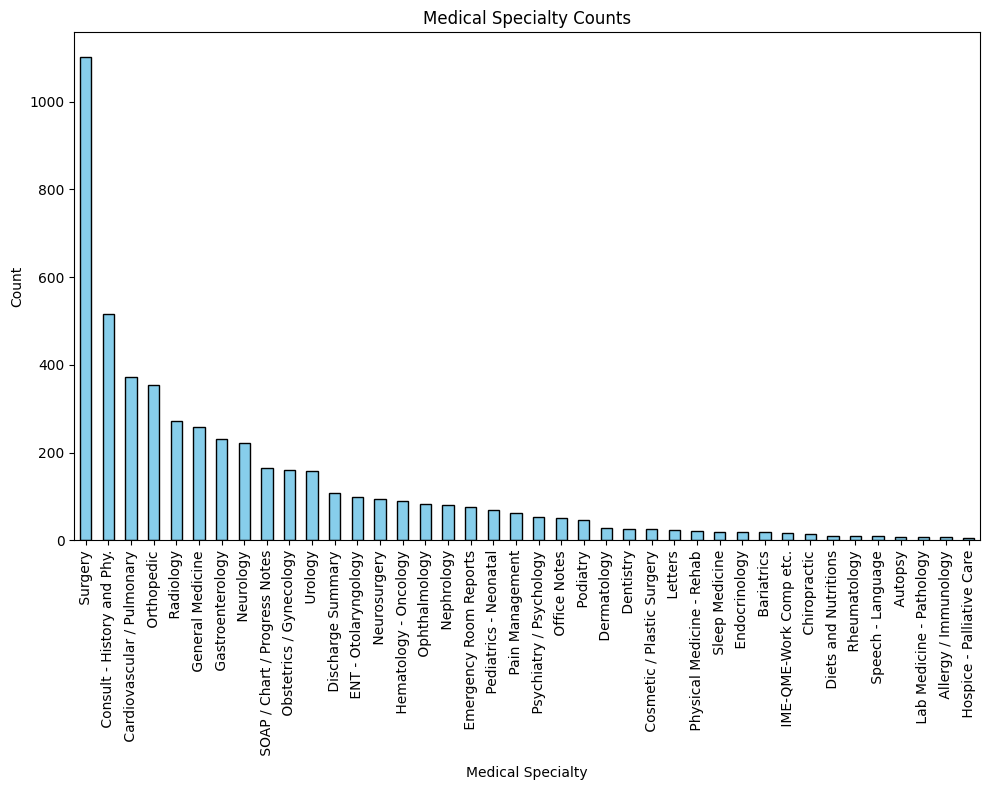

In [6]:
utils = DataUtils()
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)


Most common tokens:
Token: 'the', Frequency: 149888
Token: 'and', Frequency: 82777
Token: 'was', Frequency: 71745
Token: 'of', Frequency: 59189
Token: 'to', Frequency: 50613
Token: 'a', Frequency: 42910
Token: 'with', Frequency: 35787
Token: 'in', Frequency: 32753
Token: '.', Frequency: 31894
Token: 'is', Frequency: 26377


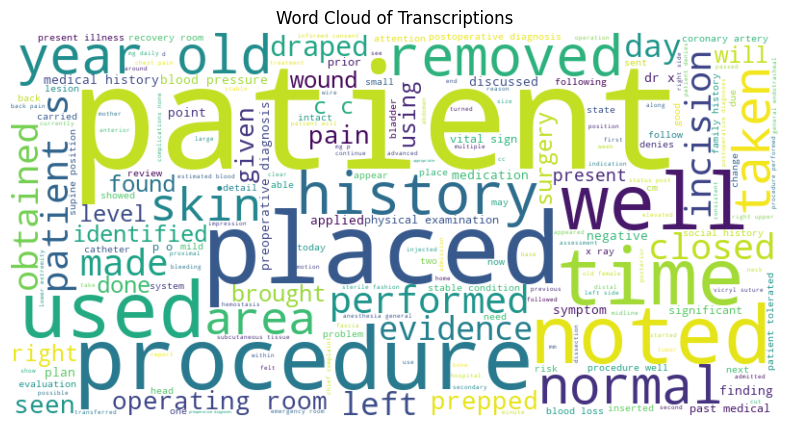

In [7]:
texts = df['transcription'].fillna('')
texts = texts.map(utils.clean_text)
tok_freq = Counter(tok for row in texts for tok in row.split() if tok)

print("\nMost common tokens:")
for tok, freq in tok_freq.most_common (10):
    print(f"Token: '{tok}', Frequency: {freq}")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcriptions")
plt.show()


             length     word_cnt
count   4999.000000  4999.000000
mean    2911.011402   469.758552
std     1934.354157   319.693225
min        0.000000     0.000000
25%     1524.000000   244.000000
50%     2538.000000   405.000000
75%     3844.000000   622.000000
max    17868.000000  3035.000000


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'word_cnt'}>]], dtype=object)

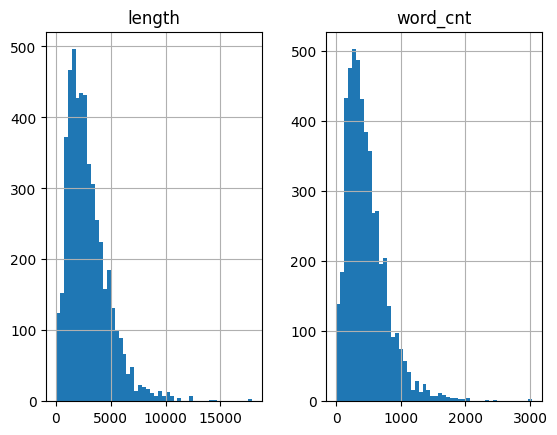

In [8]:
stats = pd.DataFrame()
stats['length'] = texts.apply(len)
stats['word_cnt'] = texts.apply(lambda x: len(x.split()))
print(f"\n{stats.describe()}")
stats.hist(bins=50)

### Methodology

Our deep learning process consists of the following steps:

* Clean and tokenize the dataset.

* Apply data augmentation/oversampling to handle class imbalance.

* Build and train the model using the Hugging Face Transformers library.

* Evaluate the trained model.

The following are our best three models for medical specialty classification:

* **Model 1: Distil-BioBERT**

   Distil-BioBERT is a distilled (smaller and faster) version of BioBERT, which is a BERT model fine-tuned on large-scale biomedical data. It offers faster training and requires fewer resources while retaining most of BioBERT’s domain-specific knowledge.

* **Model 2: DistilBERT**

   DistilBERT is a distilled (smaller and faster) version of the BERT model.  It has 40% fewer parameters than BERT while retaining about 97% of its performance (Sanh et al., 2020). Although it is trained on general domain text, it remains a strong baseline for classification tasks.

* **Model 3: RoBERTa**

   RoBERTa (Robustly Optimized BERT Pretraining Approach) is a transformer model developed by Facebook AI that builds upon the BERT architecture. It refines BERT's pretraining process to improve performance on various NLP tasks.

### Model 1: Distil-BioBERT

#### Data Preprocessing

* Removed null values and duplicate rows.

* Cleaned text by lowercasing and removing special characters.

* Merged related classes (e.g., Neurology and Neurosurgery) and removed overlapping categories (e.g., Surgery).

* Excluded any class with fewer than 100 examples.

* Applied oversampling to balance class distribution.

* Tokenized text with the Distil-BioBERT tokenizer.

In [9]:
MODEL_NAME = 'nlpie/distil-biobert'
df = pd.read_csv(DATASET_PATH, usecols=['medical_specialty', 'transcription'])

df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

df['text'] = df['transcription'].map(utils.clean_text)
df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...


===== Class Distribution =====
medical_specialty
General Medicine / SOAP / Chart / Progress Notes    425
Cardiovascular / Pulmonary                          371
Orthopedic                                          355
Neurology / Neurosurgery                            317
Gastroenterology                                    224
Urology                                             156
Obstetrics / Gynecology                             155
Discharge Summary                                   108
Name: count, dtype: int64


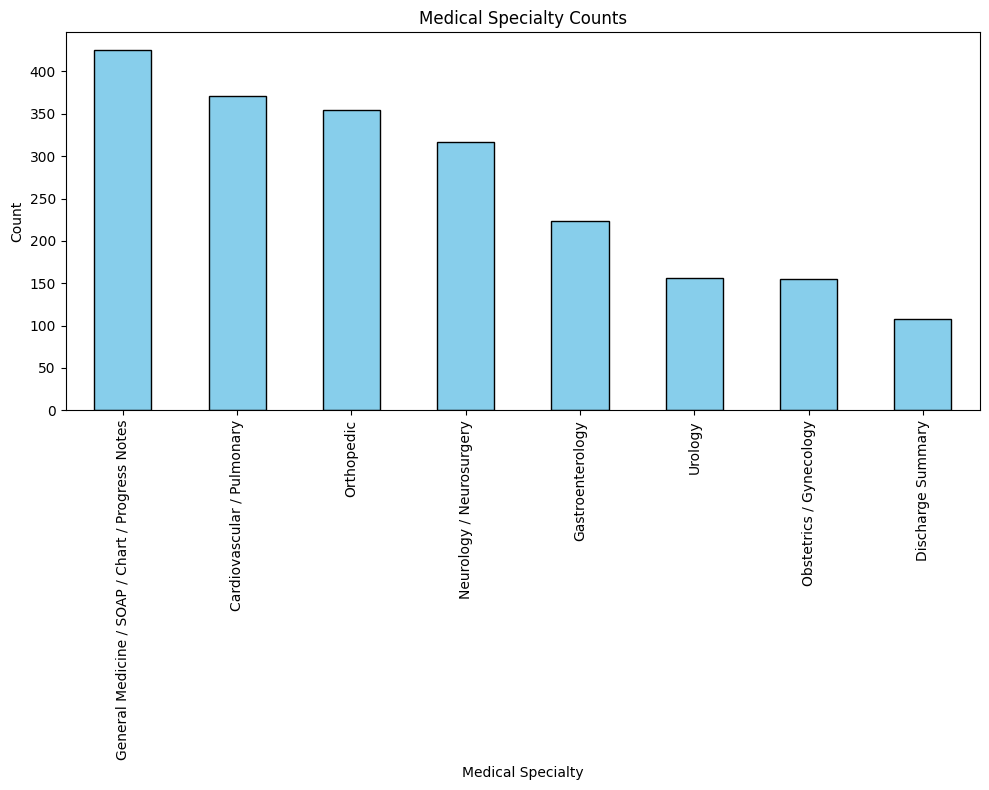

In [10]:
excluded_specialities = ['Surgery', 'Consult - History and Phy.',  'Radiology'] 
modified_df = df[~df['medical_specialty'].isin(excluded_specialities)]

modified_df['medical_specialty'] = modified_df['medical_specialty'].apply(
    lambda x: 'Neurology / Neurosurgery' if x in ['Neurology', 'Neurosurgery'] else x
)

modified_df['medical_specialty'] = modified_df['medical_specialty'].apply(
    lambda x: 'General Medicine / SOAP / Chart / Progress Notes' if x in ['General Medicine', 'SOAP / Chart / Progress Notes'] else x
)

speciality_count = utils.class_distribution(modified_df.medical_specialty, verbose=False)
modified_df = modified_df[modified_df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(modified_df.medical_specialty, 'Medical Specialty', show_plot=True)

In [11]:
def encode_label(df):
    df['label'], uniques = pd.factorize(df['medical_specialty'])
    print("Unique medical specialties:")
    for i, label in enumerate(uniques):
        print(f"{i}: {label}")
    return df, uniques

modified_df, uniques = encode_label(modified_df)
modified_df.sample(5, random_state=42)

Unique medical specialties:
0: Cardiovascular / Pulmonary
1: Neurology / Neurosurgery
2: Urology
3: General Medicine / SOAP / Chart / Progress Notes
4: Orthopedic
5: Obstetrics / Gynecology
6: Gastroenterology
7: Discharge Summary


,medical_specialty,transcription,text,label
2226,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Cellulitis with as...",preoperative diagnoses . cellulitis with assoc...,4
4853,Cardiovascular / Pulmonary,"NAME OF PROCEDURE,1. Selective coronary angio...",name of procedure . selective coronary angiogr...,0
2102,Orthopedic,"XYZ, D.C.,60 Evergreen Place,Suite 902,East Or...",xyz d.c. evergreen place suite east orange nj re,4
2209,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Painful ingrown toen...",preoperative diagnosis painful ingrown toenail...,4
1322,General Medicine / SOAP / Chart / Progress Notes,"PHYSICAL EXAMINATION:, Patient is a 46-year-o...",physical examination patient is a year old whi...,3


In [12]:
def resample_data(df):
    ros = RandomOverSampler(random_state=42)
    df_resampled, y_resampled = ros.fit_resample(
        df[['text']],
        df['label']
    )

    df_resampled['label'] = y_resampled
    print(f"Resampled Shape: {df_resampled.shape}")
    return df_resampled

df_resampled = resample_data(modified_df)

train_df, test_df = train_test_split(df_resampled, test_size=DS_SPLIT, stratify=df_resampled['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

Resampled Shape: (3400, 2)
Train Shape: (2720, 2), Test Shape: (680, 2)


In [13]:
def tokenize_data(tokenizer, train_df, test_df):
    def tokenize(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_SEQ_LEN)

    train_ds = Dataset.from_pandas(train_df)
    test_ds = Dataset.from_pandas(test_df)

    train_ds = train_ds.map(tokenize, batched=True)
    test_ds = test_ds.map(tokenize, batched=True)

    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    return train_ds, test_ds

distilbiobert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_ds, test_ds = tokenize_data(distilbiobert_tokenizer, train_df, test_df)

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

#### Model Fitting and Validation

* I chose the Distil-BioBERT model because it is highly effective at understanding domain-specific medical terminology and context. It also requires less training time and provides high accuracy on medical datasets.

* It was trained on the processed and balanced dataset using the `Trainer` API from the Transformers library.

* By default, the `Trainer` API uses the AdamW optimizer.

* I used a learning rate of 2e-5, a weight decay of 0.01, and a batch size of 16.

* I set the number of epochs to 10 and applied early stopping with a patience of 2 epochs to prevent overfitting.

In [14]:
label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

data_collator = DataCollatorWithPadding(tokenizer=distilbiobert_tokenizer)
distilbiobert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/distil-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [16]:
training_args = TrainingArguments(
    output_dir="./results",         
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    report_to="none",
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=distilbiobert_model,       
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("models/distilbiobert_classifier")

  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.7545174956321716, 'eval_accuracy': 0.7514705882352941, 'eval_f1_weighted': 0.7364038695141623, 'eval_runtime': 2.4615, 'eval_samples_per_second': 276.258, 'eval_steps_per_second': 17.469, 'epoch': 1.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.5431985855102539, 'eval_accuracy': 0.7970588235294118, 'eval_f1_weighted': 0.7886585946691063, 'eval_runtime': 2.479, 'eval_samples_per_second': 274.307, 'eval_steps_per_second': 17.346, 'epoch': 2.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.44030869007110596, 'eval_accuracy': 0.8294117647058824, 'eval_f1_weighted': 0.827605101109177, 'eval_runtime': 2.4799, 'eval_samples_per_second': 274.2, 'eval_steps_per_second': 17.339, 'epoch': 3.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.4221362769603729, 'eval_accuracy': 0.85, 'eval_f1_weighted': 0.846141454986139, 'eval_runtime': 2.4857, 'eval_samples_per_second': 273.57, 'eval_steps_per_second': 17.299, 'epoch': 4.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.4329139292240143, 'eval_accuracy': 0.8338235294117647, 'eval_f1_weighted': 0.8304745235359967, 'eval_runtime': 2.4925, 'eval_samples_per_second': 272.819, 'eval_steps_per_second': 17.252, 'epoch': 5.0}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 0.47717854380607605, 'eval_accuracy': 0.8352941176470589, 'eval_f1_weighted': 0.829950899999659, 'eval_runtime': 2.4994, 'eval_samples_per_second': 272.07, 'eval_steps_per_second': 17.204, 'epoch': 6.0}
{'train_runtime': 204.126, 'train_samples_per_second': 133.251, 'train_steps_per_second': 8.328, 'train_loss': 0.5751948337928922, 'epoch': 6.0}


#### Model Evaluation 

The best Distil-BioBERT model was achieved after epoch 4. The following are the evaluation results of the best Distil-BioBERT model:

* Accuracy: 0.8500

* Weighted F1-score: 0.8461

* Loss: 0.4221

The confusion matrix showed that the majority of misclassifications were in the "General Medicine / SOAP / Chart" category, likely because it uses terminology similar to other categories.

In [17]:
eval_results = trainer.evaluate()
print(f"Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

  0%|          | 0/43 [00:00<?, ?it/s]

Evaluation results:
eval_loss: 0.4221
eval_accuracy: 0.8500
eval_f1_weighted: 0.8461
eval_runtime: 2.5672
eval_samples_per_second: 264.8780
eval_steps_per_second: 16.7500
epoch: 6.0000


  0%|          | 0/43 [00:00<?, ?it/s]

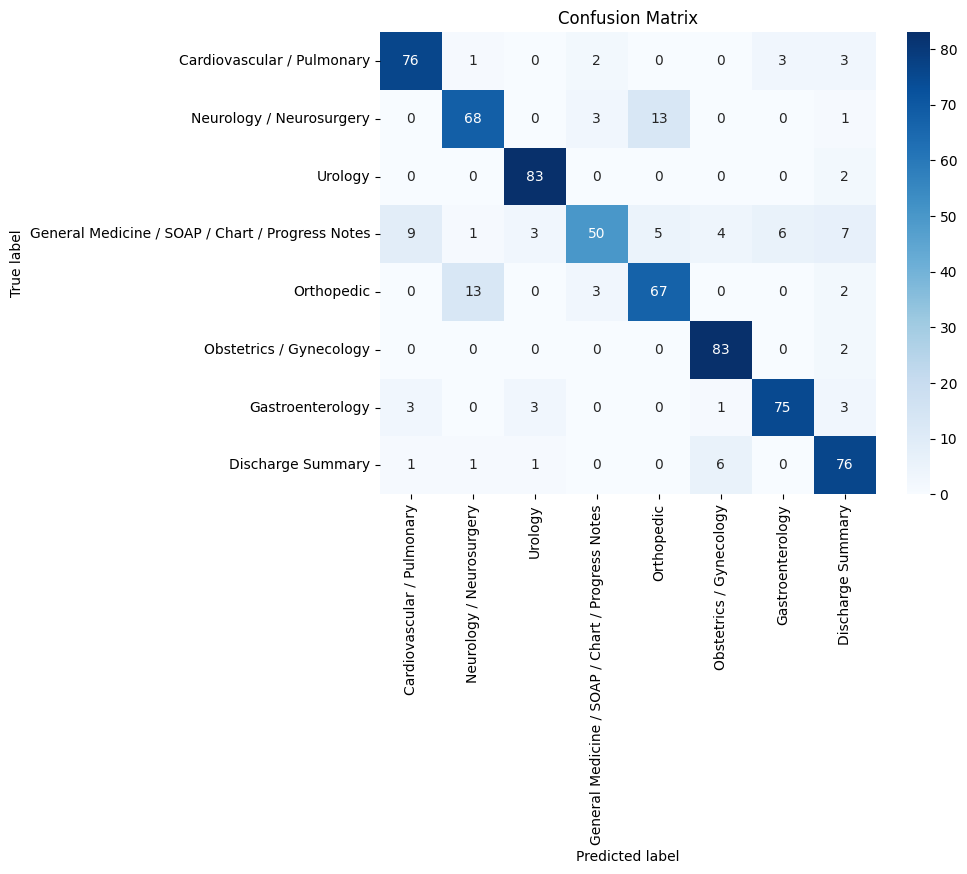

In [18]:
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

classes = list(id2label.values())
cm = confusion_matrix(y_true, y_pred)
utils.plot_confusion_matrix(cm, classes)

In [19]:
def make_predictions(tokenizer, model, test_df):
    def classify(text):
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, padding=True, max_length=MAX_SEQ_LEN)
        tokens = tokens.to(model.device)
        result = model(tokens)
        return int(torch.argmax(result.logits))
    
    samples = pd.DataFrame()
    for i in range(len(uniques)):
        sample = test_df[test_df.label == i].sample(1, random_state=21)
        samples = pd.concat([samples, sample])

    samples = samples.reset_index(drop=True)
    samples = samples.rename(columns={'label': 'true_label'})
    samples['predicted_label'] = samples['text'].apply(classify)
    return samples

make_predictions(distilbiobert_tokenizer, distilbiobert_model, test_df)

,text,true_label,predicted_label
0,comparison none. medications lopressor mg iv a...,0,0
1,chief complaint status epilepticus. history of...,1,1
2,preoperative diagnosis prostate cancer. postop...,2,2
3,history of present illness this is a year old ...,3,2
4,preoperative diagnosis volar laceration to rig...,4,4
5,preoperative diagnosis desires permanent steri...,5,5
6,chief complaint dysphagia and hematemesis whil...,6,6
7,admitting diagnoses . bradycardia. . dizziness...,7,7


### Model 2: DistilBERT

#### Data Preprocessing

* Used cleaned text from approach 1, which already handled null values and duplicate rows.

* Excluded any class with fewer than 100 examples.

* Applied oversampling to balance class distribution.

* Tokenized text with the DistilBERT tokenizer.

===== Class Distribution =====
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
Name: count, dtype: int64


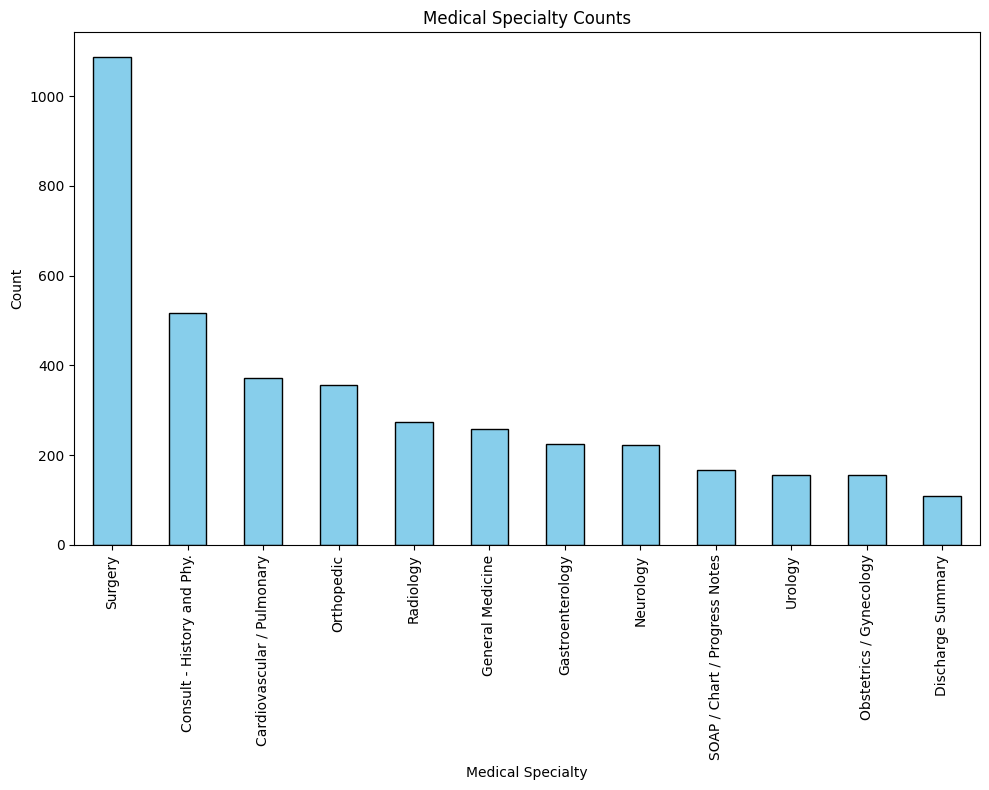

In [20]:
MODEL_NAME = 'distilbert-base-uncased'
speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df = df[df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [21]:
df, uniques = encode_label(df)
df.sample(5, random_state=42)

Unique medical specialties:
0: Cardiovascular / Pulmonary
1: Neurology
2: Urology
3: General Medicine
4: Surgery
5: SOAP / Chart / Progress Notes
6: Radiology
7: Orthopedic
8: Obstetrics / Gynecology
9: Gastroenterology
10: Discharge Summary
11: Consult - History and Phy.


,medical_specialty,transcription,text,label
2950,Neurology,The patient states that she has been doing fai...,the patient states that she has been doing fai...,1
2877,Neurology,"PREOPERATIVE DIAGNOSIS: , Right temporal lobe ...",preoperative diagnosis right temporal lobe int...,1
4179,Consult - History and Phy.,"REASON FOR CONSULTATION:, Pneumothorax and su...",reason for consultation pneumothorax and subcu...,11
2207,Orthopedic,"PREOPERATIVE DIAGNOSIS:, Foreign body, right ...",preoperative diagnosis foreign body right foot...,7
331,Surgery,"PREOPERATIVE DIAGNOSIS: , Severe scoliosis.,AN...",preoperative diagnosis severe scoliosis. anest...,4


In [22]:
df_resampled = resample_data(df)

train_df, test_df = train_test_split(df_resampled, test_size=DS_SPLIT, stratify=df_resampled['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
train_ds, test_ds = tokenize_data(distilbert_tokenizer, train_df, test_df)

Resampled Shape: (13056, 2)
Train Shape: (10444, 2), Test Shape: (2612, 2)


Map:   0%|          | 0/10444 [00:00<?, ? examples/s]

Map:   0%|          | 0/2612 [00:00<?, ? examples/s]

#### Model Fitting and Validation

* I chose the DistilBERT model because it offers a great balance between performance and computational efficiency. It delivers good accuracy for multi-class classification tasks. However, since it lacks domain-specific knowledge, it requires a large training dataset to achieve high accuracy.

* It was trained on the processed and balanced dataset using the `Trainer` API from the Transformers library.

* By default, the `Trainer` API uses the AdamW optimizer.

* I used a learning rate of 2e-5, a weight decay of 0.01, and a batch size of 16.

* I set the number of epochs to 10 and applied early stopping with a patience of 2 epochs to prevent overfitting.

In [23]:
label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id,
)
data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args = TrainingArguments(
    output_dir="./results",         
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    report_to="none",
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=distilbert_model,       
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("models/distilbert_classifier")

  0%|          | 0/6530 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.9898055195808411, 'eval_accuracy': 0.6435681470137825, 'eval_f1_weighted': 0.624853977950009, 'eval_runtime': 9.7068, 'eval_samples_per_second': 269.089, 'eval_steps_per_second': 16.895, 'epoch': 1.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.8352465629577637, 'eval_accuracy': 0.6772588055130169, 'eval_f1_weighted': 0.66091276944236, 'eval_runtime': 9.7495, 'eval_samples_per_second': 267.911, 'eval_steps_per_second': 16.821, 'epoch': 2.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7817468047142029, 'eval_accuracy': 0.6707503828483921, 'eval_f1_weighted': 0.6466294339430375, 'eval_runtime': 9.7417, 'eval_samples_per_second': 268.125, 'eval_steps_per_second': 16.835, 'epoch': 3.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7474597096443176, 'eval_accuracy': 0.6891271056661562, 'eval_f1_weighted': 0.6678451762517548, 'eval_runtime': 9.716, 'eval_samples_per_second': 268.836, 'eval_steps_per_second': 16.879, 'epoch': 4.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7202770709991455, 'eval_accuracy': 0.6849157733537519, 'eval_f1_weighted': 0.6618633615821383, 'eval_runtime': 9.7626, 'eval_samples_per_second': 267.551, 'eval_steps_per_second': 16.799, 'epoch': 5.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7025190591812134, 'eval_accuracy': 0.6898928024502297, 'eval_f1_weighted': 0.6687894354432067, 'eval_runtime': 9.6372, 'eval_samples_per_second': 271.034, 'eval_steps_per_second': 17.017, 'epoch': 6.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.6980100870132446, 'eval_accuracy': 0.6994640122511485, 'eval_f1_weighted': 0.6758644754004671, 'eval_runtime': 9.61, 'eval_samples_per_second': 271.8, 'eval_steps_per_second': 17.066, 'epoch': 7.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.6944817304611206, 'eval_accuracy': 0.6895099540581929, 'eval_f1_weighted': 0.6687000189816678, 'eval_runtime': 9.7461, 'eval_samples_per_second': 268.004, 'eval_steps_per_second': 16.827, 'epoch': 8.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.6988497972488403, 'eval_accuracy': 0.6967840735068913, 'eval_f1_weighted': 0.6718166098432092, 'eval_runtime': 9.9293, 'eval_samples_per_second': 263.061, 'eval_steps_per_second': 16.517, 'epoch': 9.0}
{'train_runtime': 1175.3023, 'train_samples_per_second': 88.862, 'train_steps_per_second': 5.556, 'train_loss': 0.7559037415454314, 'epoch': 9.0}


#### Model Evaluation 

The best DistilBERT model was achieved after epoch 7. The following are the evaluation results of the best DistilBERT model:

* Accuracy: 0.6995

* Weighted F1-score: 0.6759

* Loss: 0.6980

The confusion matrix indicated that the majority of misclassifications were in the "Surgery" and "Consult - History and Phy." categories.

In [25]:
eval_results = trainer.evaluate()
print(f"Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

  0%|          | 0/164 [00:00<?, ?it/s]

Evaluation results:
eval_loss: 0.6980
eval_accuracy: 0.6995
eval_f1_weighted: 0.6759
eval_runtime: 10.1802
eval_samples_per_second: 256.5760
eval_steps_per_second: 16.1100
epoch: 9.0000


  0%|          | 0/164 [00:00<?, ?it/s]

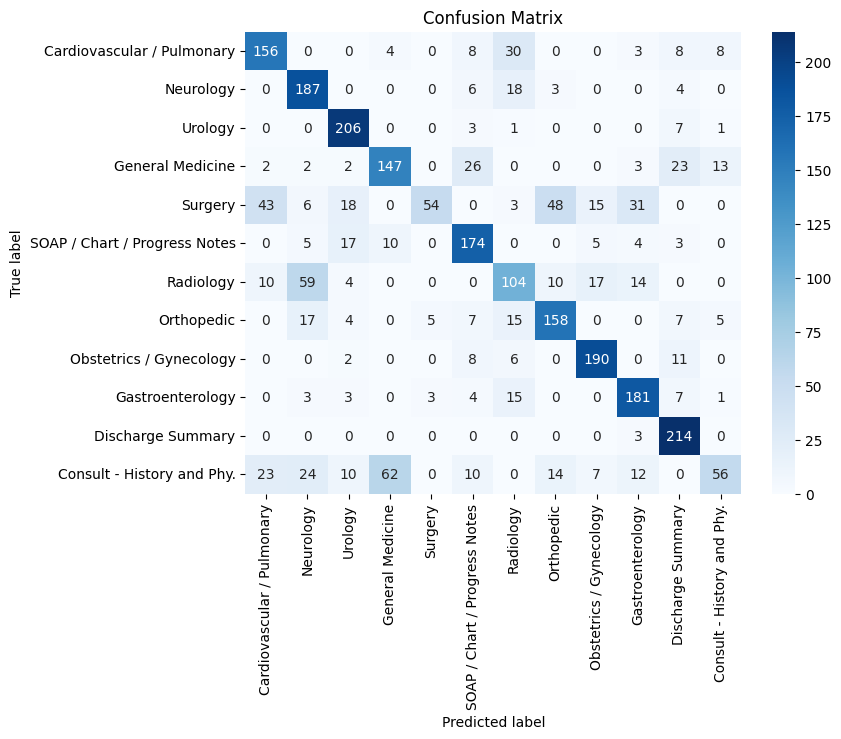

,text,true_label,predicted_label
0,history of present illness this is a year old ...,0,3
1,interpretation mri of the cervical spine witho...,1,1
2,preoperative diagnosis right inguinal hernia. ...,2,2
3,subjective this year old man presents to the e...,3,3
4,procedures performed phenol neurolysis left mu...,4,1
5,subjective the patient returns to the pulmonar...,5,5
6,history advanced maternal age and hypertension...,6,8
7,preoperative diagnoses . post anterior cervica...,7,7
8,preoperative diagnoses multiparity requested s...,8,8
9,preoperative diagnosis possible inflammatory b...,9,9


In [26]:
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

classes = list(id2label.values())
cm = confusion_matrix(y_true, y_pred)
utils.plot_confusion_matrix(cm, classes)

make_predictions(distilbert_tokenizer, distilbert_model, test_df)

### Model 3: RoBERTa

#### Data Preprocessing

* Removed null values and duplicate rows.

* Grouped classes with fewer than 100 examples into an “Other” category.

* Generated a numeric class label for each category.

* Concatenated pre-extracted keywords with the transcription text.

In [27]:
df = pd.read_csv(DATASET_PATH, usecols=['keywords', 'transcription', 'medical_specialty'])    

utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty       0
transcription          33
keywords             1068
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 0


===== Class Distribution =====
medical_specialty
Surgery                          1021
other                             888
Orthopedic                        303
Cardiovascular / Pulmonary        280
Radiology                         251
Consult - History and Phy.        234
Gastroenterology                  195
Neurology                         168
General Medicine                  146
SOAP / Chart / Progress Notes     142
Urology                           140
Obstetrics / Gynecology           130
Name: count, dtype: int64


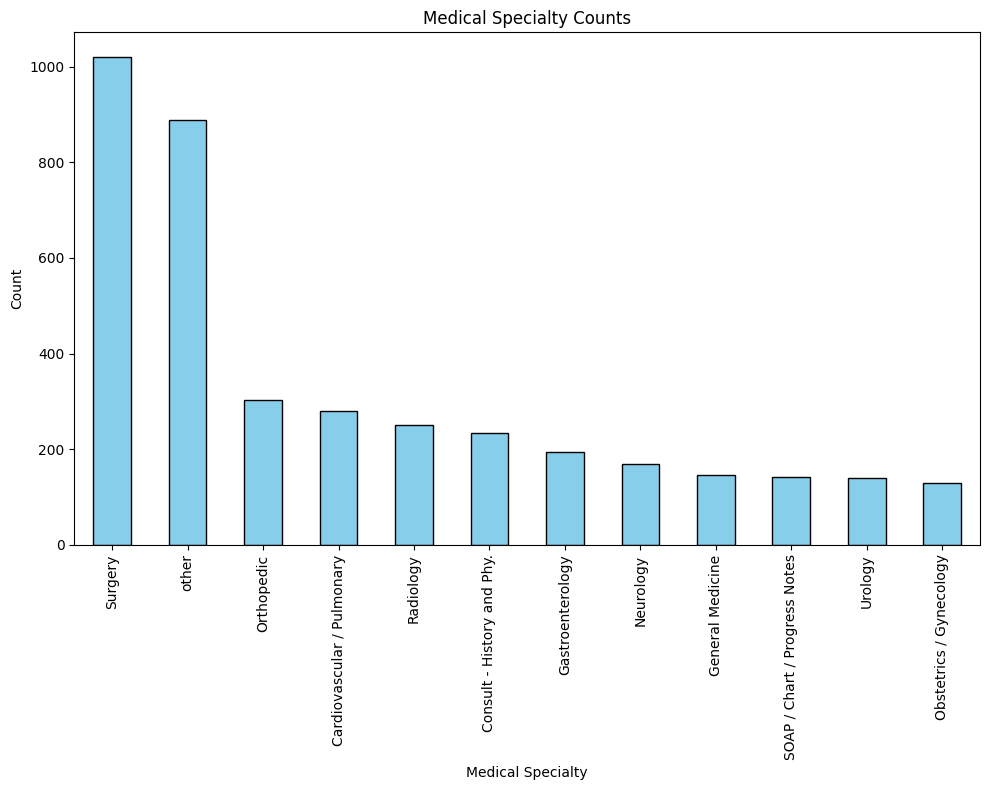

In [28]:
speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: x if speciality_count[x] >= MIN_SPECIALITY_THRESHOLD else 'other')
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [29]:
df, uniques = encode_label(df)
df.sample(5, random_state=42)

Unique medical specialties:
0: other
1: Cardiovascular / Pulmonary
2: Urology
3: General Medicine
4: Surgery
5: SOAP / Chart / Progress Notes
6: Radiology
7: Orthopedic
8: Obstetrics / Gynecology
9: Neurology
10: Gastroenterology
11: Consult - History and Phy.


,medical_specialty,transcription,keywords,label
4700,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION:, Pneumothorax and su...","cardiovascular / pulmonary, trauma, tracheobro...",1
988,Surgery,"PREPROCEDURE DIAGNOSIS: , Colon cancer screeni...","surgery, colon polyps, diverticulosis, hemorrh...",4
346,Surgery,"PREOPERATIVE DIAGNOSIS: , Shunt malfunction. ...","surgery, ventriculoatrial shunt, endoscopic pr...",4
2384,other,"PREOPERATIVE DIAGNOSIS:, Ruptured globe with ...","ophthalmology, ruptured globe, alphagan, bss, ...",0
1628,Radiology,"EXAM: , Digital screening mammogram.,HISTORY:,...","radiology, mediolateral, craniocaudal, fibrogl...",6


In [30]:
dataset = pd.DataFrame({
    'text' : df['keywords']+df['transcription'],
    'label' : df['label']
})

train_df, test_df = train_test_split(dataset, test_size=DS_SPLIT, stratify=dataset['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

Train Shape: (3118, 2), Test Shape: (780, 2)


#### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [31]:
MODEL_TYPE = 'roberta'
MODEL_NAME = 'roberta-base'

def compute_metrics(pred, actual):
    return {
        "accuracy": balanced_accuracy_score(actual, pred),
        "f1_weighted": f1_score(actual, pred, average="weighted")
    }

In [32]:
cuda_available = torch.cuda.is_available()
num_classes = len(uniques)

model_args = ClassificationArgs(
    num_train_epochs=10,
    learning_rate=1e-5,
    reprocess_input_data=True,
    save_model_every_epoch=False,
    overwrite_output_dir= True,
    use_early_stopping=True,
    early_stopping_patience=2,
    early_stopping_metric="mcc",
    early_stopping_delta=0.005
)

roberta_model = ClassificationModel(
    MODEL_TYPE,
    MODEL_NAME,
    num_labels=num_classes,
    weight=[1]*num_classes,
    use_cuda=cuda_available,
    args=model_args
)

roberta_model.train_model(train_df, eval_df=test_df, custom_eval_function=compute_metrics)
roberta_model.model.save_pretrained("models/roberta_classifier")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/390 [00:00<?, ?it/s]

#### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [33]:
eval_result, _, _ = roberta_model.eval_model(test_df)
y_pred, _ = roberta_model.predict(test_df['text'].values.tolist())
pred_result = compute_metrics(y_pred, test_df['label'])

print(f"MCC: {eval_result['mcc']}, Eval_Loss: {eval_result['eval_loss']}")
print(f"Accuracy: {pred_result['accuracy']}, F1 Score: {pred_result['f1_weighted']}")

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

MCC: 0.9744162211208431, Eval_Loss: 0.1283326599514112
Accuracy: 0.9769504119031573, F1 Score: 0.9782743226812359


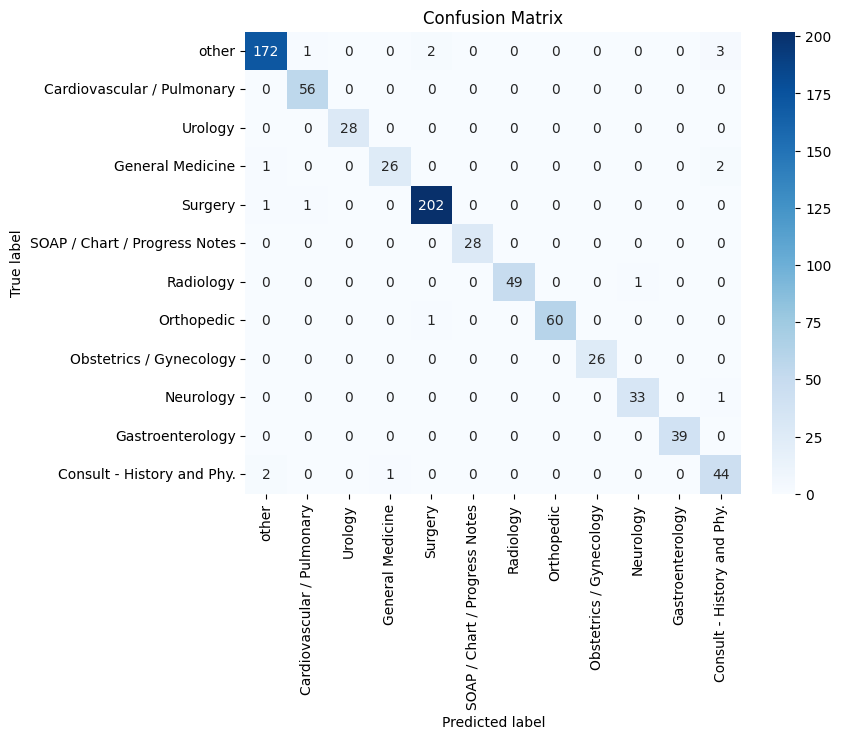

In [34]:
classes = [uniques[i] for i in range(len(uniques))]
cm = confusion_matrix(test_df['label'], y_pred)
utils.plot_confusion_matrix(cm, classes)

In [35]:
samples = pd.DataFrame()
for i in range(len(uniques)):
    sample = test_df[test_df.label == i].sample(1, random_state=21)
    samples = pd.concat([samples, sample])

samples = samples.reset_index(drop=True)
samples = samples.rename(columns={'label': 'true_label'})
samples['predicted_label'], _ = roberta_model.predict(samples['text'].tolist())
samples

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,text,true_label,predicted_label
0,"podiatry, debrided, nails, dystrophic nails, d...",0,0
1,"cardiovascular / pulmonary, ventricular arrhyt...",1,1
2,"urology, iodine-125 seed implantation, seed im...",2,2
3,"general medicine, swelling, iv hydration, oste...",3,3
4,"surgery, posterolateral chest, stab wound, lid...",4,4
5,"soap / chart / progress notes, jak-2 positive ...",5,5
6,"radiology, coronary artery cta, calcium scorin...",6,6
7,"orthopedic, painful right knee, total knee art...",7,7
8,"obstetrics / gynecology, dilatation and curett...",8,8
9,"neurology, alpha activity, wave activity, hype...",9,9


### Issues / Improvements
1. Dataset is very small
2. Use regularization / initialization
3. Use cross-validaiton
4. ...

###  References

* Rajapakse, T. C., Yates, A., & de Rijke, M. (2024). Simple Transformers: Open-source for all. In *Proceedings of the 2024 Annual International ACM SIGIR Conference on Research and Development in Information Retrieval in the Asia Pacific Region* (SIGIR-AP 2024, pp. 209–215). Association for Computing Machinery. https://doi.org/10.1145/3673791.3698412

* Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2020). *DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter*. https://arxiv.org/pdf/1910.01108

* Harsha Vemuluru. (2021, July 11). *Bert-medical-classifier*. Kaggle.com; Kaggle. https://www.kaggle.com/code/harshavemu/bert-medical-classifier

### Credits

* Model 3 is based on Vemuluru's Bert-medical-classifier code. During my review of related studies, I found that this code achieved the highest accuracy for medical classification. Therefore, I decided to use a similar approach in our project. [(Harsha Vemuluru, 2021)](https://www.kaggle.com/code/harshavemu/bert-medical-classifier)